In [1]:
from model_3 import *
from data_3 import *
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  2


In [28]:
N_training = 1000
N_validate = 10
batch_size = 4

train_ids = np.arange(N_training)
print(train_ids)
train_generator = DataGenerator(train_ids, '../training_data_v1/', '../training_data_v1/', do_fft = False, batch_size = batch_size)

validation_ids = np.arange(N_training, N_training+N_validate)
print(validation_ids)
validation_generator = DataGenerator(validation_ids, '../training_data_v1/', '../training_data_v1/', do_fft = False, batch_size = batch_size)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

In [29]:
with tf.device('/GPU:1'):
    model = unet(init_layers=64, input_size = (256,256,50), output_channels=50)
    print(model.summary())

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 50 0                                            
__________________________________________________________________________________________________
conv2d_69 (Conv2D)              (None, 256, 256, 64) 28864       input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_70 (Conv2D)              (None, 256, 256, 64) 36928       conv2d_69[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_12 (MaxPooling2D) (None, 128, 128, 64) 0           conv2d_70[0][0]                  
____________________________________________________________________________________________

In [30]:
with tf.device('/GPU:1'):
    hist = model.fit_generator(train_generator, validation_data= validation_generator, epochs=8)

Epoch 1/8
250/250 [==============================] - 268s 1s/step - loss: 0.0089 - mean_squared_error: 0.0179 - val_loss: 0.0085 - val_mean_squared_error: 0.0170
Epoch 2/8
250/250 [==============================] - 177s 709ms/step - loss: 0.0081 - mean_squared_error: 0.0162 - val_loss: 0.0084 - val_mean_squared_error: 0.0167
Epoch 3/8
250/250 [==============================] - 173s 693ms/step - loss: 0.0075 - mean_squared_error: 0.0150 - val_loss: 0.0068 - val_mean_squared_error: 0.0135
Epoch 4/8
250/250 [==============================] - 177s 709ms/step - loss: 0.0072 - mean_squared_error: 0.0143 - val_loss: 0.0080 - val_mean_squared_error: 0.0160
Epoch 5/8
250/250 [==============================] - 174s 698ms/step - loss: 0.0068 - mean_squared_error: 0.0137 - val_loss: 0.0071 - val_mean_squared_error: 0.0143
Epoch 6/8
250/250 [==============================] - 174s 695ms/step - loss: 0.0066 - mean_squared_error: 0.0132 - val_loss: 0.0068 - val_mean_squared_error: 0.0135
Epoch 7/8
250

In [23]:
# Load test data
cardiac_test = np.load('../tagsim/test_data_v1.npz')

truth_data = cardiac_test['truth'].transpose((1,2,0))
test_data = cardiac_test['test'].transpose((1,2,0))

out_shape = np.array((1,) + truth_data.shape)
out_shape[-1] *= 2

X = np.zeros(out_shape)
y = np.zeros(out_shape)

X[0, :,:,::2] = np.real(test_data)
X[0, :,:,1::2] = np.imag(test_data)

y[0, :,:,::2] = np.real(truth_data)
y[0, :,:,1::2] = np.imag(truth_data)

print(X.shape)

with tf.device('/GPU:2'):
    res = model.predict(X)

(1, 256, 256, 50)


In [26]:
ii_gen = iter(validation_generator)

for i in range(2):
    X, y = next(ii_gen)
    
res = model.predict(X)
print(res.shape)

(4, 256, 256, 50)


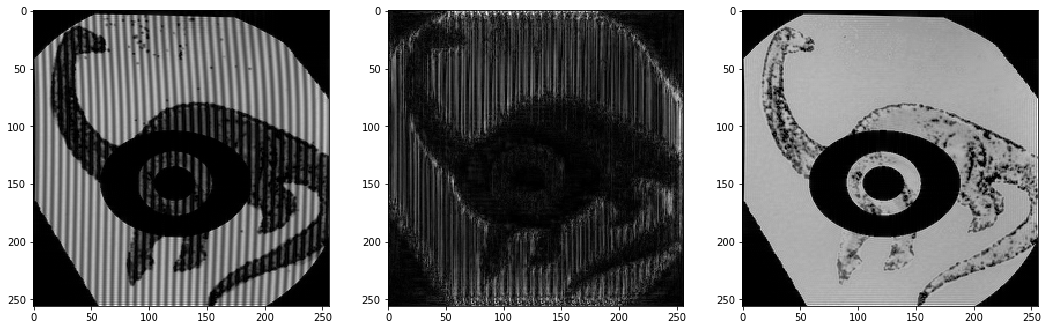

In [27]:
tt = 11

im_X = X[0,:,:,tt*2] + 1j * X[0,:,:,tt*2+1]
im_res = res[0,:,:,tt*2] + 1j * res[0,:,:,tt*2+1]
im_truth = y[0,:,:,tt*2] + 1j * y[0,:,:,tt*2+1]

fig, axs = plt.subplots(1, 3, squeeze=False, figsize=(18,8))

axs[0,0].imshow((np.abs(im_X)), cmap='gray')
axs[0,1].imshow((np.abs(im_res)), cmap='gray')
axs[0,2].imshow((np.abs(im_truth)), cmap='gray')

In [5]:
# Load test data
cardiac_test = np.load('../tagsim/test_data_v1.npz')

truth_data = cardiac_test['truth']

test_data = cardiac_test['test']

X = np.zeros(test_data.shape + (2,))
y = np.zeros(truth_data.shape + (2,))

X[:,:,:,0] = np.real(test_data)
X[:,:,:,1] = np.imag(test_data)

y[:,:,:,0] = np.real(truth_data)
y[:,:,:,1] = np.imag(truth_data)

with tf.device('/GPU:2'):
    res = model.predict(X)

In [6]:
print(X.shape)
print(y.shape)

(25, 256, 256, 2)
(25, 256, 256, 2)


In [7]:
with tf.device('/GPU:1'):
    hist = model.fit_generator(train_generator, validation_data= (X,y) , epochs=12)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/12
937/937 [==============================] - 504s 538ms/step - loss: 0.0016 - mean_squared_error: 0.0031 - val_loss: 6.3768e-04 - val_mean_squared_error: 0.0013
Epoch 2/12
937/937 [==============================] - 501s 535ms/step - loss: 8.9586e-04 - mean_squared_error: 0.0018 - val_loss: 6.4992e-04 - val_mean_squared_error: 0.0013
Epoch 3/12
937/937 [==============================] - 502s 535ms/step - loss: 7.8760e-04 - mean_squared_error: 0.0016 - val_loss: 5.4855e-04 - val_mean_squared_error: 0.0011
Epoch 4/12
937/937 [==============================] - 501s 535ms/step - loss: 7.2125e-04 - mean_squared_error: 0.0014 - val_loss: 2.8781e-04 - val_mean_squared_error: 5.7561e-04
Epoch 5/12
937/937 [==============================] - 501s 535ms/step - loss: 6.8687e-04 - mean_squared_error: 0.0014 - val_loss: 3.4628e-04 - val_mean_squared_error: 6.9256e-04
Epoch 6/12
937/937 [==============================

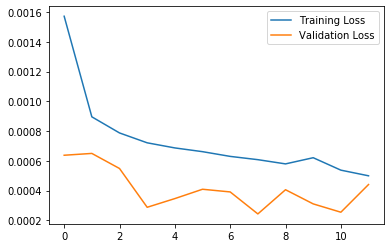

In [8]:
plt.figure()
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.legend()

In [10]:
plt.figure()
plt.imshow(np.log(np.abs(np.fft.fftshift(np.fft.fft2(np.fft.fftshift(im_X))))))

plt.figure()
plt.imshow(np.log(np.abs(np.fft.fftshift(np.fft.fft2(np.fft.fftshift(im_res[11]))))))

plt.figure()
plt.imshow(np.log(np.abs(np.fft.fftshift(np.fft.fft2(np.fft.fftshift(im_truth[11]))))))

NameError: name 'im_X' is not defined

<Figure size 432x288 with 0 Axes>

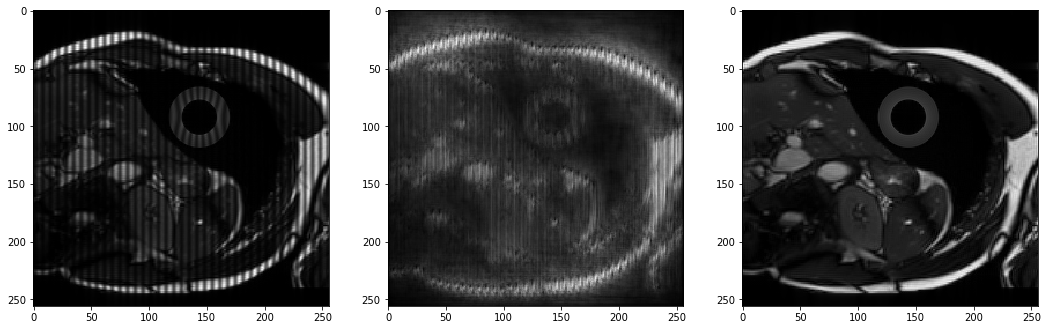

In [11]:
#Visualize magnitude of input, results, truth

tt = 11

im_X = X[tt,:,:,0] + 1j * X[tt,:,:,1]
im_res = res[tt,:,:,0] + 1j * res[tt,:,:,1]
im_truth = truth_data[tt]

fig, axs = plt.subplots(1, 3, squeeze=False, figsize=(18,8))

axs[0,0].imshow((np.abs(im_X)), cmap='gray')
axs[0,1].imshow((np.abs(im_res)), cmap='gray')
axs[0,2].imshow((np.abs(im_truth)), cmap='gray')

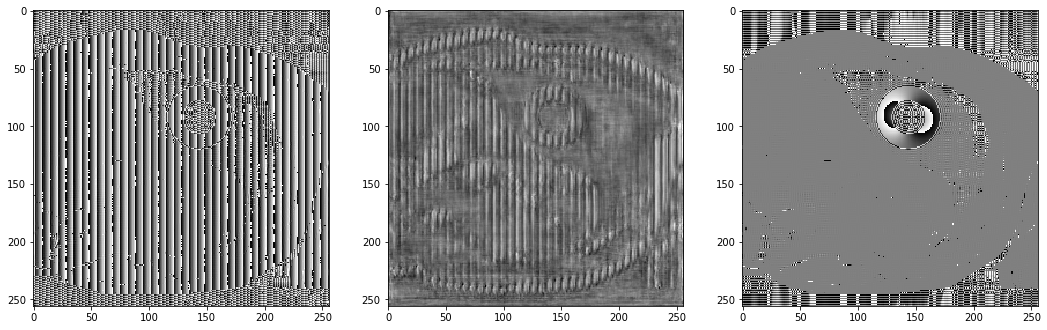

In [12]:
#Visualize phase of input, results, truth

tt = 11

im_X = X[tt,:,:,0] + 1j * X[tt,:,:,1]
im_res = res[tt,:,:,0] + 1j * res[tt,:,:,1]
im_truth = truth_data[tt]

fig, axs = plt.subplots(1, 3, squeeze=False, figsize=(18,8))

axs[0,0].imshow((np.angle(im_X)), cmap='gray')
axs[0,1].imshow((np.angle(im_res)), cmap='gray')
axs[0,2].imshow((np.angle(im_truth)), cmap='gray')

Time resolved mean error: [0.96500105, 0.9515384, 0.95983005, 0.96939254, 0.9828257, 0.7993082, 0.51279, 0.22943455, -0.040202476, -0.112036906, -0.24206087, -0.31499285, -0.32632458, -0.32638112, -0.298206, -0.22652699, -0.149608, -0.0031538545, 0.27350715, 0.65129435, 0.9077374, 0.93075264, 0.93126166, 0.9324114, 0.9252203]
Time resolved stdev error: [0.43198806, 0.54968226, 0.8365565, 1.1900026, 1.5250155, 1.9023885, 2.2192175, 2.427327, 2.53268, 2.5788047, 2.5980444, 2.597569, 2.5923252, 2.580618, 2.562899, 2.5258877, 2.475548, 2.392444, 2.2452936, 1.9741125, 1.5742894, 1.2147238, 0.864236, 0.55586547, 0.42180642]
Total Error: 1.7595571 mm  +/- 1.1636698 mm


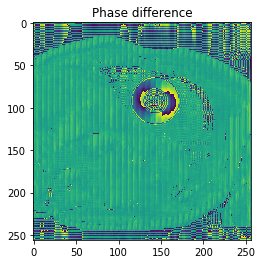

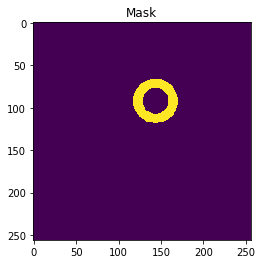

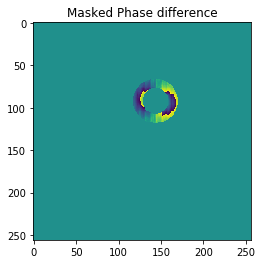

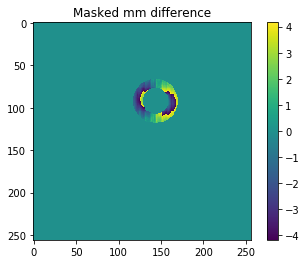

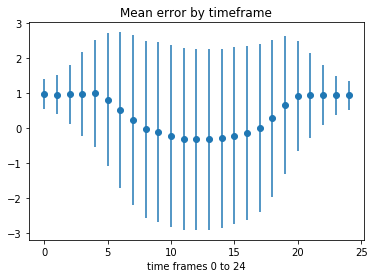

In [13]:
# Compute error:

# Phase difference of results and truth
im_res = res[:,:,:,0] + 1j * res[:,:,:,1]
im_truth = truth_data
ph_diff = np.angle(im_res * np.exp(-1j * np.angle(im_truth)))


# Plot phase difference
tt_show = 11  # timeframe to look at
plt.figure()
plt.imshow(ph_diff[tt_show])
plt.title('Phase difference')

# We dont actually care about anything but the hard, I saved a mask in the test dataset
mask = cardiac_test['mask']
plt.figure()
plt.imshow(mask[tt_show])
plt.title('Mask')

# Multiply results by the mask
ph_diff_mask = ph_diff * mask
plt.figure()
plt.imshow(ph_diff_mask[tt_show])
plt.title('Masked Phase difference')

# Convert to mm error
ke = 0.12 # This was set in simulation
mm_diff_mask = ph_diff_mask / (2*np.pi) / ke
plt.figure()
plt.imshow(mm_diff_mask[tt_show])
plt.colorbar()
plt.title('Masked mm difference')

# Calculate mean and standard deviation error, time frame specific
# We mask differently because we don't want to incorporate all the zeros from masking
err_mean = []
err_std = []
for tt in range(im_res.shape[0]):
    t_diff = mm_diff_mask[tt, mask[tt]>0]
    err_mean.append(t_diff.mean())
    err_std.append(t_diff.std())

print('Time resolved mean error:', err_mean)
print('Time resolved stdev error:', err_std)
x_ax = np.arange(25)
plt.figure()
plt.errorbar(x_ax, err_mean, yerr = err_std, fmt='o')
plt.title('Mean error by timeframe')
plt.xlabel("time frames 0 to 24")

# And the total error as a single metric
total_err = mm_diff_mask[mask>0]
print('Total Error:', np.abs(total_err).mean(), 'mm  +/-', np.abs(total_err).std(), 'mm')

## Tuning ideas
* Use all timeframes together
  * As channels (3D convolutions will be too expensive)
* Operate in k-space
* Which loss function is best
* Operate in image space, but loss function in k-space
* Play with activation functions, where to use batch normalization, learning rate adjustments, batch size
* Check initial image normalization (zero mean, stdev = 1)

## Implement validation, test data
* Validate on different simulations
* Test on the cardiac simulation
* Eventually we will test on our acquired DENSE data (I need to prep it)

In [ ]:
list(cardiac_test.keys())

In [ ]:
X.shape

In [ ]:
X.shape